In [ ]:
import os
import shutil
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tqdm import tqdm
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
import time
from tempfile import TemporaryDirectory
import torch.optim as optim
from torchvision import datasets, models, transforms
import torch.nn as nn

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
data_dir = '/content/drive/My Drive/Masked Bottomwear'
test_size = 0.2
csv_path = '/content/drive/MyDrive/filtered_data_updated2.csv'

Mounted at /content/drive


In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [ ]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    running_corrects = 0

    # Wrap the dataloader with tqdm for a progress bar
    for inputs, labels in tqdm(dataloader, desc="Training", leave=False):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(True):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects.double() / len(dataloader.dataset)

    return epoch_loss, epoch_acc

In [ ]:
def val_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    # Wrap the dataloader with tqdm for a progress bar
    for inputs, labels in tqdm(dataloader, desc="Validation", leave=False):
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects.double() / len(dataloader.dataset)

    return epoch_loss, epoch_acc

In [ ]:
def train_model(model, criterion, optimizer, scheduler, dataloaders, device, num_epochs=25):
    since = time.time()

    # Lists to store losses and accuracies
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Training phase
            train_loss, train_acc = train_epoch(model, dataloaders['train'], criterion, optimizer, device)
            train_losses.append(train_loss)
            train_accuracies.append(train_acc.item())
            print(f'Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}')

            # Validation phase
            val_loss, val_acc = val_epoch(model, dataloaders['val'], criterion, device)
            val_losses.append(val_loss)
            val_accuracies.append(val_acc.item())
            print(f'Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}')

            # Step the scheduler
            scheduler.step()

            # Save the best model
            if val_acc > best_acc:
                best_acc = val_acc
                torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # Load the best model weights
        model.load_state_dict(torch.load(best_model_params_path))

    # Plotting the losses and accuracies
    plt.figure(figsize=(12, 4))

    # Plot losses
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracies
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

    return model

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
model_ft = models.resnet101()
model_ft = models.resnet101(weights=models.ResNet101_Weights.IMAGENET1K_V1)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 5)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:00<00:00, 184MB/s]


Epoch 0/11
----------


Train Loss: 1.1628 Acc: 0.5722


Val Loss: 0.5093 Acc: 0.8317

Epoch 1/11
----------


Train Loss: 0.9631 Acc: 0.6603


Val Loss: 0.7240 Acc: 0.7317

Epoch 2/11
----------


Train Loss: 0.7491 Acc: 0.7393


Val Loss: 0.6034 Acc: 0.8268

Epoch 3/11
----------


Train Loss: 0.7028 Acc: 0.7485


Val Loss: 0.5537 Acc: 0.8122

Epoch 4/11
----------


Train Loss: 0.5933 Acc: 0.7803


Val Loss: 0.4985 Acc: 0.8171

Epoch 5/11
----------


Train Loss: 0.5548 Acc: 0.8084


Val Loss: 0.3566 Acc: 0.8707

Epoch 6/11
----------


Train Loss: 0.5311 Acc: 0.8164


Val Loss: 0.2741 Acc: 0.9171

Epoch 7/11
----------


Train Loss: 0.3721 Acc: 0.8782


Val Loss: 0.2412 Acc: 0.9341

Epoch 8/11
----------


Train Loss: 0.3605 Acc: 0.8684


Val Loss: 0.2033 Acc: 0.9488

Epoch 9/11
----------


Train Loss: 0.3143 Acc: 0.8953


Val Loss: 0.2001 Acc: 0.9439

Epoch 10/11
----------


Train Loss: 0.3338 Acc: 0.8837


Val Loss: 0.2069 Acc: 0.9415

Epoch 11/11
----------


Train Loss: 0.2878 Acc: 0.9027


Val Loss: 0.2134 Acc: 0.9390

Training complete in 38m 56s
Best val Acc: 0.948780


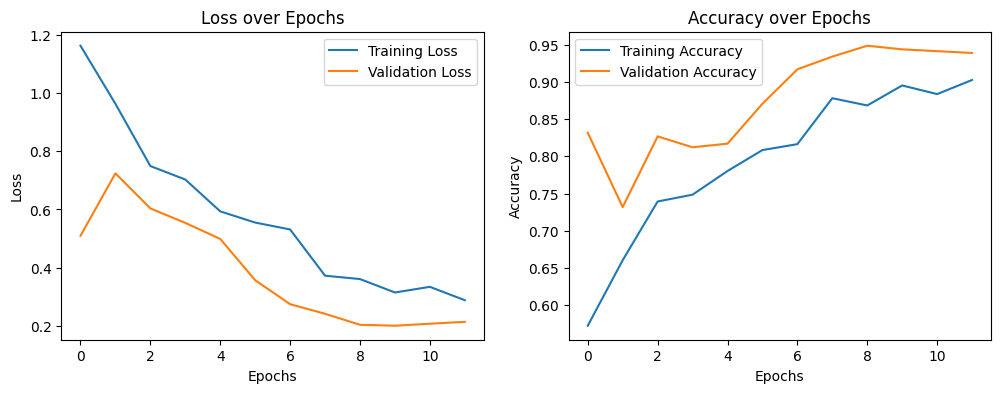

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, dataloaders, device, num_epochs=12)

In [ ]:
torch.save(model_ft.state_dict(), 'Bottomwear_classification_94.pth')